In [1]:
!cythonize -i *.pyx --force # this should be done for each user as different headers might be used for different py versions

zsh:1: no matches found: *.pyx


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import multiprocessing as mp
from time import time

from matplotlib import pyplot as plt
from parallelqueue.base_models import *
from parallelqueue.monitors import *

ncpus = mp.cpu_count() - 12
print(ncpus)

class Concurrent:
    def __init__(self, maxtime=1000, SArgs=1, AArgs=2, d=2, r=2,
                 order=range(2, 1000, 2), seed=123):
        self.rhoJSim = None
        self.r = r
        self.order = order
        self.d = d
        self.AArgs = AArgs
        self.SArgs = SArgs
        print(f"rho = {AArgs / SArgs}")
        self.maxtime = maxtime
        self._ts = None
        self.seed = seed

    def rhochange(self, which=2):
        self.order = range(2, 30, 1)
        labels = {self.rhoRSim: f"Redundancy({self.d})", self.rhoJSim: f"JSQ({self.d})",
                  self.rhoTSim: f"Thresh({self.d},{self.r})"}
        test = list(labels.keys())[which]
        print(f"Running {test}")
        results = self.ParallelSim(test)
        # i is {N, copies}
        self.res = pd.DataFrame({i[0]: i[1] for i in results}, index=[i[0] for i in results][::-1])  # have to reverse
        self.res.plot(kind="bar", legend=None)
        plt.title("Average Time in System for Varying rho and N")
        self.__init__()  # Re-init

    def WriteEach(self, simrep=1, of=["TSim"], ts=True):
        """                   v rep within run
        res['Thresh(2,2)'][0][0].keys()
                           ^run (N-size)
        Out[9]: dict_keys(['ReplicaSets', 'TimeQueueSize'])"""
        self._ts = ts
        self._sims = simrep
        labels = {self.RSim: f"Redundancy({self.d})", self.JSim: f"JSQ({self.d})",
                  self.TSim: f"Thresh({self.d},{self.r})"}
        self.res = {}
        for sim in [self.__getattribute__(i) for i in of]:
            print(f"Running {sim}")
            self.res[labels[sim]] = self.ParallelSim(sim)  # Annoying to unpack ¯\_(ツ)_/¯

    def DoEach(self, of=["TSim"], iters=1):
        self._ts = False
        labels = {self.RSim: f"Redundancy({self.d})", self.JSim: f"JSQ({self.d})",
                  self.TSim: f"Thresh({self.d},{self.r})"}
        self.res = {}
        for sim in [self.__getattribute__(i) for i in of]:
            print(f"Running {sim}")
            results = self.ParallelSim(sim)
            self.res[labels[sim]] = pd.DataFrame(results)
        for k, v in self.res.items():
            plt.plot(v, label=k)
        plt.legend()
        if iters == 1:
            plt.title("Average Time in System as N → ∞")

    def RSim(self, reps):
        mons = [TimeQueueSize]
        testvalues = []
        for N in (self.order):
            _sim = RedundancyQueueSystem(maxTime=self.maxtime, parallelism=N, seed=self.seed + 2331 * N + reps,
                                         d=self.d,
                                         Arrival=random.expovariate,
                                         AArgs=self.AArgs, Service=random.expovariate, SArgs=self.SArgs,
                                         Monitors=mons)
            _sim.RunSim()
            testvalues.append(_sim.MonitorOutput)
        if not self._ts:
            return np.array(testvalues)
        else:
            return np.mean(testvalues)

    def JSim(self, reps):
        mons = [TimeQueueSize]
        testvalues = []
        for N in (self.order):
            _sim = JSQd(maxTime=self.maxtime, parallelism=N, seed=self.seed + 2331 * N + reps, d=self.d,
                        Arrival=random.expovariate,
                        AArgs=self.AArgs, Service=random.expovariate, SArgs=self.SArgs,
                        Monitors=mons)
            _sim.RunSim()
            testvalues.append(_sim.MonitorOutput)
        if not self._ts:
            return np.array(testvalues)
        else:
            return np.mean(testvalues)

    def TSim(self, reps):
        mons = [TimeQueueSize]
        testvalues = []
        for N in (self.order):
            _sim = RedundancyQueueSystem(maxTime=self.maxtime, parallelism=N, seed=self.seed + 2331 * N + reps,
                                         d=self.d,
                                         r=self.r,
                                         Arrival=random.expovariate,
                                         AArgs=self.AArgs, Service=random.expovariate, SArgs=self.SArgs,
                                         Monitors=mons)
            _sim.RunSim()
            testvalues.append(_sim.MonitorOutput)
        if not self._ts:
            return np.array(testvalues)
        else:
            return np.mean(testvalues)

    def rhoTSim(self, N):
        testvalues = []
        for i in range(2, 30, 1):
            _sim = RedundancyQueueSystem(maxTime=self.maxtime, parallelism=i, seed=self.seed + 2331 * N + i, d=self.d,
                                         r=self.r,
                                         Arrival=random.expovariate,
                                         AArgs=self.AArgs + (N / 10), Service=random.expovariate, SArgs=self.SArgs,
                                         Monitors=[ReplicaSets])
            print(f"testing rho = {self.AArgs + (N / 10)}@i={i}")
            _sim.RunSim()
            interim = pd.DataFrame(_sim.MonitorOutput["ReplicaSets"]).transpose()
            testvalues.append((pd.DataFrame(interim["exit"] - interim["entry"]).mean()).values)
        return [N / 10, [i[0] for i in testvalues]]

    def rhoRSim(self, N):
        testvalues = []
        for i in range(2, 30, 1):
            _sim = RedundancyQueueSystem(maxTime=self.maxtime, parallelism=i, seed=self.seed + 2331 * N + i, d=self.d,
                                         Arrival=random.expovariate,
                                         AArgs=self.AArgs + (N / 10), Service=random.expovariate, SArgs=self.SArgs,
                                         Monitors=[ReplicaSets])
            print(f"testing rho = {self.AArgs + (N / 10)}@i={i}")
            _sim.RunSim()
            interim = pd.DataFrame(_sim.MonitorOutput["ReplicaSets"]).transpose()
            testvalues.append((pd.DataFrame(interim["exit"] - interim["entry"]).mean()).values)
        return [N / 10, [i[0] for i in testvalues]]

    def ParallelSim(self, sim):
        with mp.Pool(processes=ncpus) as p:
            res = p.map(sim, range(self._sims))
        return res

    def Results(self):
        return self.res


def SafeRun(maxtime=1000, SArgs=1, AArgs=2, d=2, r=2, order=range(2, 20, 2),
            of="TSim", seed=123, simrep=1, ts=True):  # Throws out Concurrent when done
    run = Concurrent(maxtime, SArgs, AArgs, d, r, order, seed)
    run.WriteEach(of=[of], simrep=simrep, ts=ts)
    return run.Results()


from redundancy.pqTools import fileMaker

# In[ ]:


12


In [111]:

#ToOrder = [25, 50, 100, 500, 1000]
ToOrder = [100]
results = SafeRun(of="TSim", order=ToOrder, maxtime=1000, AArgs=5, SArgs=0.1, simrep=10, ts=False, seed=64)
results = results[list(results.keys())[0]] #
# print("Saving")
# fileMaker(results, list(range(len(ToOrder))))

rho = 50.0
Running <bound method Concurrent.TSim of <__main__.Concurrent object at 0x7f9c8b449b20>>


In [112]:
results=results[0][0]["TimeQueueSize"] # sim[order[time[queue&counts]]
print("breakpoint")


# results2 = SafeRun(of="JSim", order=ToOrder, maxtime=1000, AArgs=5, simrep=10, ts=False, seed=1021)
# results2 = results2[list(results2.keys())[0]]
#
#
#
# results3 = SafeRun(of="RSim", order=ToOrder, maxtime=1000, AArgs=5, simrep=10, ts=False, seed=1111)
# results3 = results3[list(results3.keys())[0]]


breakpoint


In [113]:
df0=pd.DataFrame(results).transpose().iloc[-100:,:]

In [114]:
from redundancy import hsic

In [115]:
test,thresh=hsic.HSIC_permutations(np.array([df0.index,df0[0].array]).transpose(),np.array([df0.index,df0[1].array]).transpose(),0.01, 30)
print(f"Reject null (H_0: Indep processes): {test > thresh}\n"
      f"-------------------------\n"
      f"HSIC statistic: {test}\n"
      f"Threshold: {thresh}")

Reject null (H_0: Indep processes): True
-------------------------
HSIC statistic: 0.0027693505039096955
Threshold: 0.00014824513426647812


<AxesSubplot:>

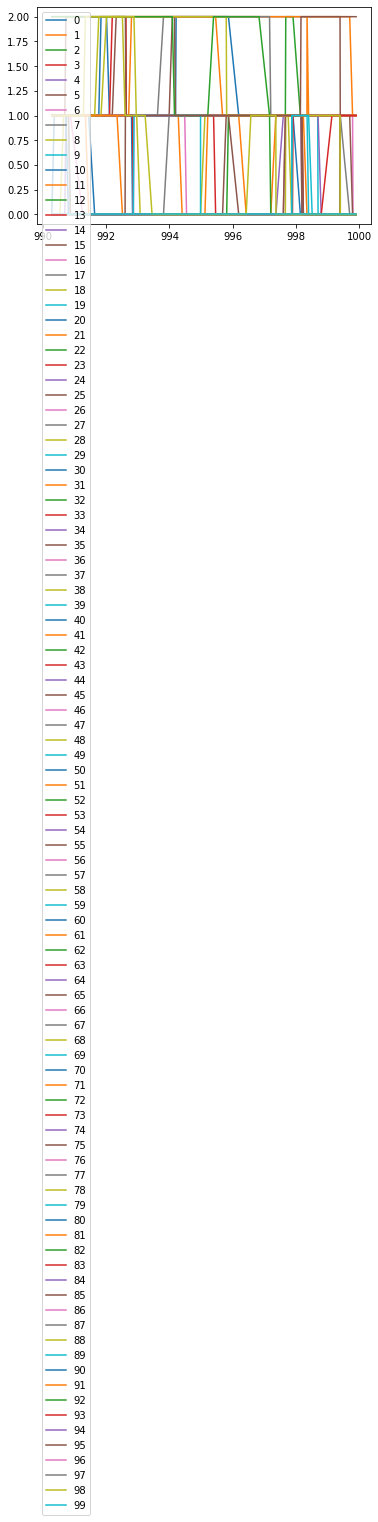

In [116]:
df0.plot()